## Crack segmentation on asphalt photos- DL

### Maria Musial 156062
### Martyna Stasiak 156071

In [114]:
import os
import random
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, 
    Flatten, Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
)
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
import keras_tuner as kt
from tf_keras_vis.utils.scores import CategoricalScore, BinaryScore
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize
import random
from matplotlib.colors import Normalize

## Loading data
We are reading paths and extracting binary information about existence of cracks from mask photos. 

In [4]:
np.random.seed(44)  #A imie jego czterdziesci i cztery...
tf.random.set_seed(44)

df = pd.DataFrame({
    "filepath": [],
    "label": []
})

images_directory = "./train/images"
masks_directory = "./train/masks"
images = []
labels = []
for img_name in os.listdir(images_directory):
    img_path = os.path.join(images_directory, img_name)
    
    mask_path = os.path.join(masks_directory, img_name)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    
    label = "1" if np.any(mask>0) else "0" 
    
    labels.append(label)
    df.loc[len(df)] = [img_path, label]
labels = np.array(labels)

#SPLITTING DATA FOR VALIDATION AND TRAINING
train_df, val_df = train_test_split(df, test_size=0.2, random_state=44, stratify=df["label"])

-----------
## Data augumentation
**Rescale**- We rescale the image to values <0,1> <br>
**Shear range**- shear transfomation to simulate distortions <br>
**Zoom_range**- randomly zooms image 80% to 120% of its original size. for more variation<br>
**Rotation range-** rotation of image up to 1 degree. As we dont have only perfectly horizontal/vertical lines<br>
**Width shift range**- shifts the image horizontally by a fraction of its width<br>
**Horizontal flip**- true: randomly flips the image horizontally <br>
**Fill mode**- reflect to mirror edge pixels of the image to fill faps<br>
<br><br>
All those settings give simillar images and enough variety to have well augumented data.


No data augumentation for validation, as we need to validate data, but we need rescaling to <0,1>. 

In [3]:
# Define the data generator for augumentation

datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.01,      
    zoom_range=(0.8, 1.2),  
    rotation_range=5,   
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    brightness_range=(0.8, 0.9),
    fill_mode='reflect'
)

#Load images from dataframe
train_generator = datagen.flow_from_dataframe(
    dataframe = train_df,  
    x_col = "filepath",
    y_col = "label",
    target_size=(128, 128),  
    class_mode="binary",  
    batch_size=16,
    shuffle=True,
    seed=44
)

#Defining dynamic creation of validation data
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_dataframe(
    dataframe = val_df,
    x_col = "filepath",
    y_col = "label",
    target_size = (128, 128),
    batch_size = 16,
    class_mode = 'binary'
)
validation_steps = len(val_generator)

Found 7682 validated image filenames belonging to 2 classes.
Found 1921 validated image filenames belonging to 2 classes.


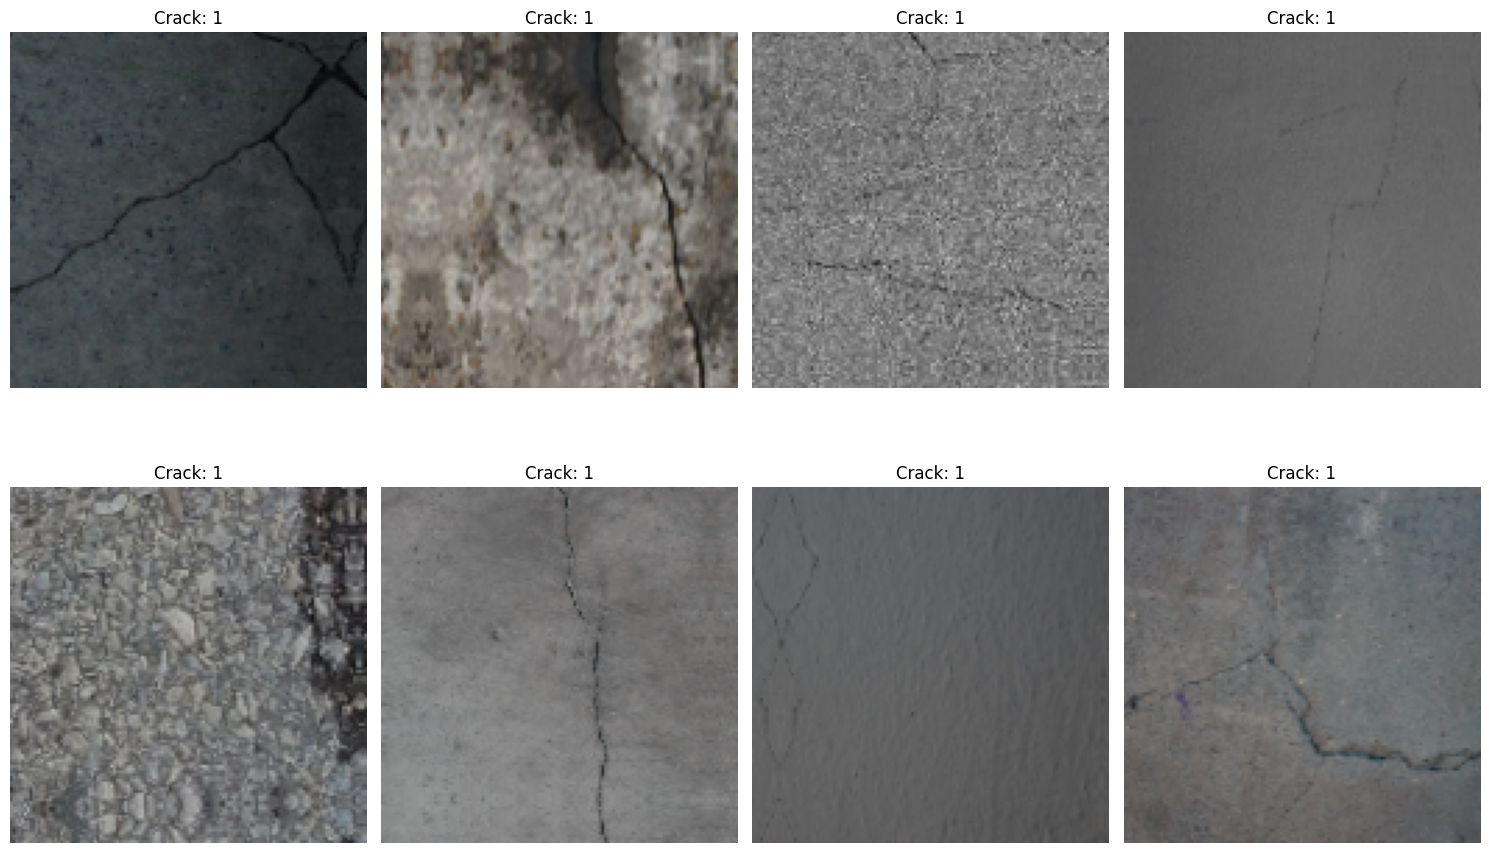

In [4]:
# Function to plot augmented images
def plot_augmented_images(generator, n_rows=2, n_cols=4):
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 10))
    axs = axs.flatten()  # Flatten the array of axes for easier indexing

    # Generate one batch of images and labels
    images, labels = next(generator)  

    for i in range(len(axs)):
        if i < len(images):  # Ensure we don't go out of bounds
            img = images[i]
            img = (img * 255).astype(np.uint8)

            axs[i].imshow(img)
            axs[i].set_title(f"Crack: {int(labels[i])}")  
            axs[i].axis('off')
        else:
            axs[i].axis('off')  

    plt.tight_layout()
    plt.show()

plot_augmented_images(train_generator)

---------
## Models - architecture selection

#### I also checked transfer learning from ResNet50 on other file, but it was computationally expensive and not worth the results.

### We are using keras_tuner to check for best architecture.

##### Get data for hyperparameter tuning. Only a subset for efficiency

In [12]:
# Load and preprocess images
def load_and_preprocess_image(image_path, target_size=(128, 128)):
    image = load_img(image_path, target_size=target_size)  # Load and resize image
    image = img_to_array(image) / 255.0  # Normalize pixel values
    return image

# Load the DataFrame
df_hyper = val_df.copy()

df_hyper['image'] = df_hyper['filepath'].apply(load_and_preprocess_image)
X_val = np.array(df_hyper['image'].tolist())
y_val = df_hyper['label'].values.astype(int)

In [13]:
def build_model(hp):
    model = Sequential()
    model.add(Input((128, 128, 3)))
    # Input Layer
    model.add(
        Conv2D(
            filters=hp.Choice('filters_layer_0', values=[16, 32, 64]),
            kernel_size=(3, 3),
            activation='relu'
        )
    )
    model.add(MaxPooling2D((2, 2)))

    # Dynamically Adding Convolutional Layers
    for i in range(hp.Int('num_layers', min_value=2, max_value=5)):
        model.add(
            Conv2D(
                filters=hp.Choice(f'filters_layer_{i}', values=[16, 32, 64]),
                kernel_size=(3, 3),
                activation='relu',
                padding='same'
            )
        )
        model.add(MaxPooling2D((2, 2)))

        # Optional Batch Normalization
        if hp.Boolean(f'batch_norm_layer_{i}'):
            model.add(BatchNormalization())

    # Flatten for Dense Layers
    model.add(Flatten())

    # Dense Layers
    model.add(
        Dense(
            units=hp.Int('dense_units', min_value=32, max_value=128, step=32),
            activation='relu'
        )
    )

    # Optional Dropout
    if hp.Boolean('use_dropout'):
        model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))

    # Output Layer
    model.add(Dense(1, activation='sigmoid'))

    # Compiling the Model
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3])
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
        # metrics=['accuracy', tf.keras.metrics.AUC(), 'precision', 'recall']
    )

    return model


In [14]:
tuner = kt.RandomSearch(
    build_model,
    max_trials=20,
    executions_per_trial=1,
    objective="val_accuracy",
    directory="tuning",
    project_name="hyperband_tuning"
)

Reloading Tuner from tuning\hyperband_tuning\tuner0.json


In [15]:
#not used, possibly more efficient
# tuner = kt.Hyperband(
#     build_model,
#     objective="val_accuracy",
#     max_epochs=20,
#     factor=3,  # Determines the reduction factor for successive trials in Hyperband. A higher factor reduces the number of trials but increases the focus on promising configurations.
#     directory="tuning",
#     project_name="hyperband_tuning",
# )

In [16]:
tuner.search_space_summary()


Search space summary
Default search space size: 9
filters_layer_0 (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64], 'ordered': True}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
batch_norm_layer_0 (Boolean)
{'default': False, 'conditions': []}
filters_layer_1 (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64], 'ordered': True}
batch_norm_layer_1 (Boolean)
{'default': False, 'conditions': []}
dense_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
use_dropout (Boolean)
{'default': False, 'conditions': []}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
dropout_rate (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}


We are using only validation data, so we're using only subset of data to determine best architecture. Its more computationally efficient, but tells us what we need to know about architectures

In [17]:
tuner.search(X_val, y_val, validation_split=0.2, epochs=10) 

Trial 20 Complete [00h 01m 12s]
val_accuracy: 0.9454545378684998

Best val_accuracy So Far: 0.948051929473877
Total elapsed time: 01h 06m 21s


### Best parameters

In [24]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best number of layers: {best_hps.get('num_layers')}")
print(f"Best filters for layer 0: {best_hps.get('filters_layer_0')}")
print(f"Best filters for other layers: {[best_hps.get(f'filters_layer_{i}') for i in range(best_hps.get('num_layers'))]}")
print(f"Best batch normalization: {[best_hps.get(f'batch_norm_layer_{i}') for i in range(best_hps.get('num_layers'))]}")
print(f"Best dense units: {best_hps.get('dense_units')}")
print(f"Use dropout: {best_hps.get('use_dropout')}")
if best_hps.get('use_dropout'):
    print(f"Dropout rate: {best_hps.get('dropout_rate')}")
print(f"Best learning rate: {best_hps.get('learning_rate')}")


Best number of layers: 5
Best filters for layer 0: 16
Best filters for other layers: [16, 32, 32, 16, 16]
Best batch normalization: [False, True, False, False, False]
Best dense units: 96
Use dropout: False
Best learning rate: 0.001


### Building and train the best model


In [ ]:
best_model = tuner.hypermodel.build(best_hps)
best_model.compile(
    optimizer=Adam(learning_rate=0.001), 
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(), 'precision', 'recall']
)
best_model.summary()


callbacks = [
    ModelCheckpoint('best_model_hyperparametered.keras', monitor='val_loss', save_best_only=True, mode='min'),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    TensorBoard(log_dir='logs')  
]
history = best_model.fit(train_generator, validation_data=val_generator, epochs=50, callbacks=callbacks, verbose=1)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)              │ (None, 126, 126, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 63, 63, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 31, 31, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 31, 31, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 15, 15, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 15, 15, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 7, 7, 16)       │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 3, 3, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 3, 3, 16)       │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 1, 1, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 96)             │         1,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            97 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,457 (99.44 KB)

 Trainable params: 25,393 (99.19 KB)

 Non-trainable params: 64 (256.00 B)

Epoch 1/50
481/481 ━━━━━━━━━━━━━━━━━━━━ 65s 129ms/step - accuracy: 0.8780 - auc: 0.7907 - loss: 0.3180 - precision: 0.9007 - recall: 0.9609 - val_accuracy: 0.8714 - val_auc: 0.4807 - val_loss: 0.9205 - val_precision: 0.8714 - val_recall: 1.0000
Epoch 2/50
481/481 ━━━━━━━━━━━━━━━━━━━━ 53s 110ms/step - accuracy: 0.9207 - auc: 0.8923 - loss: 0.2225 - precision: 0.9416 - recall: 0.9695 - val_accuracy: 0.9115 - val_auc: 0.8947 - val_loss: 0.2585 - val_precision: 0.9547 - val_recall: 0.9432
Epoch 3/50
481/481 ━━━━━━━━━━━━━━━━━━━━ 49s 101ms/step - accuracy: 0.9378 - auc: 0.9170 - loss: 0.1908 - precision: 0.9501 - recall: 0.9805 - val_accuracy: 0.9204 - val_auc: 0.9202 - val_loss: 0.2152 - val_precision: 0.9568 - val_recall: 0.9516
Epoch 4/50
481/481 ━━━━━━━━━━━━━━━━━━━━ 51s 107ms/step - accuracy: 0.9429 - auc: 0.9248 - loss: 0.1769 - precision: 0.9508 - recall: 0.9856 - val_accuracy: 0.9328 - val_auc: 0.9240 - val_loss: 0.1981 - val_precision: 0.9612 - val_recall: 0.9618
Epoch 5/50
481/481 ━

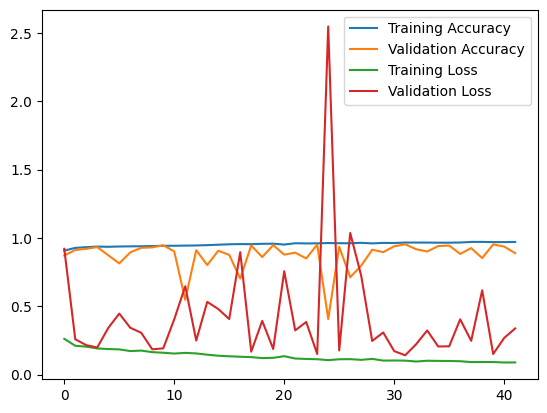

In [31]:
def plot_history(hist):
    plt.plot(hist.history['accuracy'], label='Training Accuracy')
    plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
    plt.plot(hist.history['loss'], label='Training Loss')
    plt.plot(hist.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.show()

plot_history(history)

-----------
## Evlauating the chosen architecture


In [11]:
test_df = pd.DataFrame({
    "filepath": [],
    "label": []
})

images_directory = "./test/images"
masks_directory = "./test/masks"
labels = []
for img_name in os.listdir(images_directory):
    img_path = os.path.join(images_directory, img_name)
    
    mask_path = os.path.join(masks_directory, img_name)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    
    label = "1" if np.any(mask>0) else "0" 
    
    labels.append(label)
    test_df.loc[len(test_df)] = [img_path, label]
labels = np.array(labels)

In [ ]:
#Defining new generator for test data
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="filepath",
    y_col="label",
    target_size=(128, 128),
    batch_size=16,
    class_mode='binary',
    shuffle=False  # Keep order for reproducibility
)

Found 1695 validated image filenames belonging to 2 classes.


In [34]:
best_model.metrics

[<Mean name=loss>, <CompileMetrics name=compile_metrics>]

In [35]:
# Evaluating the model
test_loss, test_accuracy, test_auc, test_precision, test_recall = best_model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test AUC: {test_auc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")

C:\Users\mary9\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


106/106 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.9664 - auc: 0.5636 - loss: 0.0928 - precision: 0.9724 - recall: 0.9889
Test Loss: 0.1392
Test Accuracy: 0.9499
Test AUC: 0.9665
Test Precision: 0.9590
Test Recall: 0.9844


### On paper it looks good. But when looking at saliency maps i saw that the model focused mainly on one corner. I tested another model, and it provided good evaluation and more explainable results later. 

In [ ]:
# Binary CNN

modelBinCNN = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')],
    name="BinCNN")

modelBinCNN.compile(
    optimizer=Adam(learning_rate=0.001), 
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(), 'precision', 'recall']
)
modelBinCNN.summary()

In [ ]:
callbacks = [
    ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min'),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    TensorBoard(log_dir='logs')  # Logs for TensorBoard
]
historyBin = modelBinCNN.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=callbacks,
    verbose=1
)


### Now, because its running for 1:30h on my computer, i wont be running this here. I have the model saved already.  The graph is copied from another testing jupyter where I fitted the model 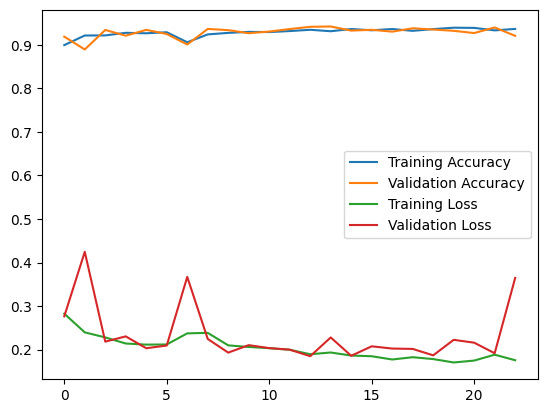

#### We can see better convergence, less jumps for validation. That tells me that this model is better fitted.

In [132]:
model = load_model("best_model.keras")   #This is this model, saved

--------------
## Result analysis

In [133]:
correctly_classified_images = []
incorrectly_classified_images = []

predi=test_df.copy()

for index, row in predi.iterrows():
    image_path = row['filepath']
    true_label = row['label']
    
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    target_size = (128, 128)
    image_resized = cv2.resize(image, target_size)
    image_normalized = image_resized / 255.0
    image_input = np.expand_dims(image_normalized, axis=0)
    
    predictions = model.predict(image_input, verbose=0)
    predicted_label = (predictions > 0.5).astype(int)[0][0]
    
    if predicted_label == int(true_label):
        correctly_classified_images.append([image, true_label, predicted_label, image_path])
    else:
        incorrectly_classified_images.append([image, true_label, predicted_label, image_path])
print(f"Number of correctly classified {len(correctly_classified_images)}, and not correctly: {len(incorrectly_classified_images)})



1571 124


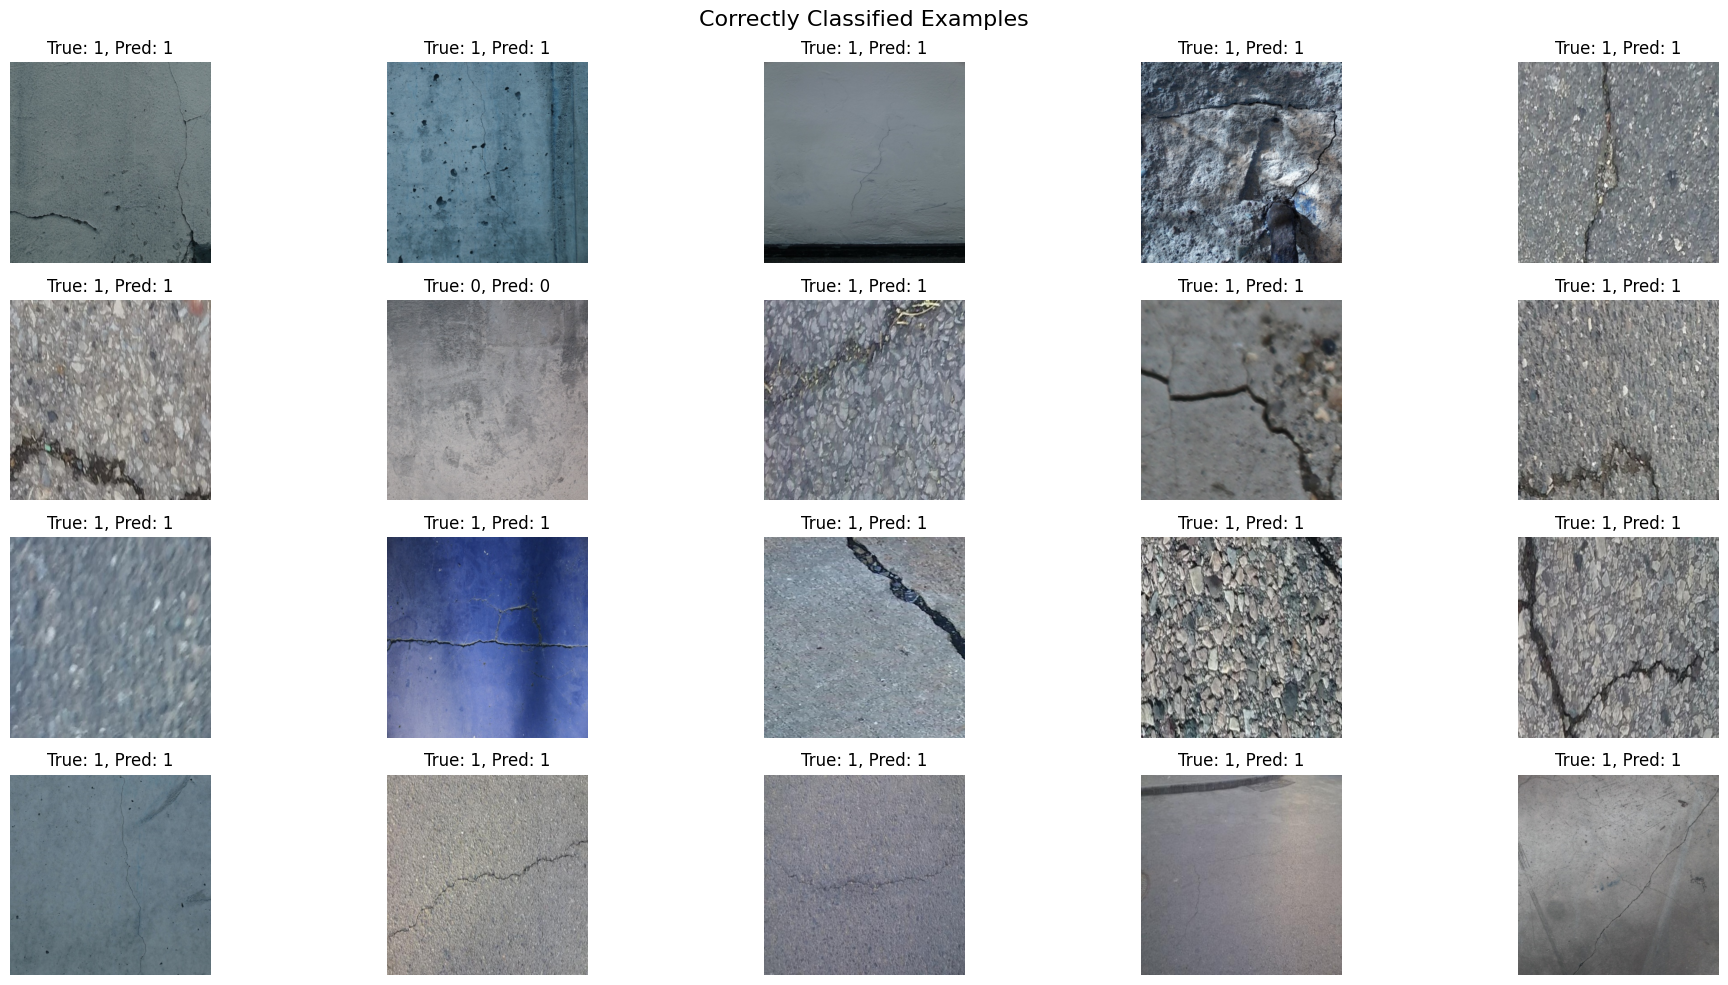

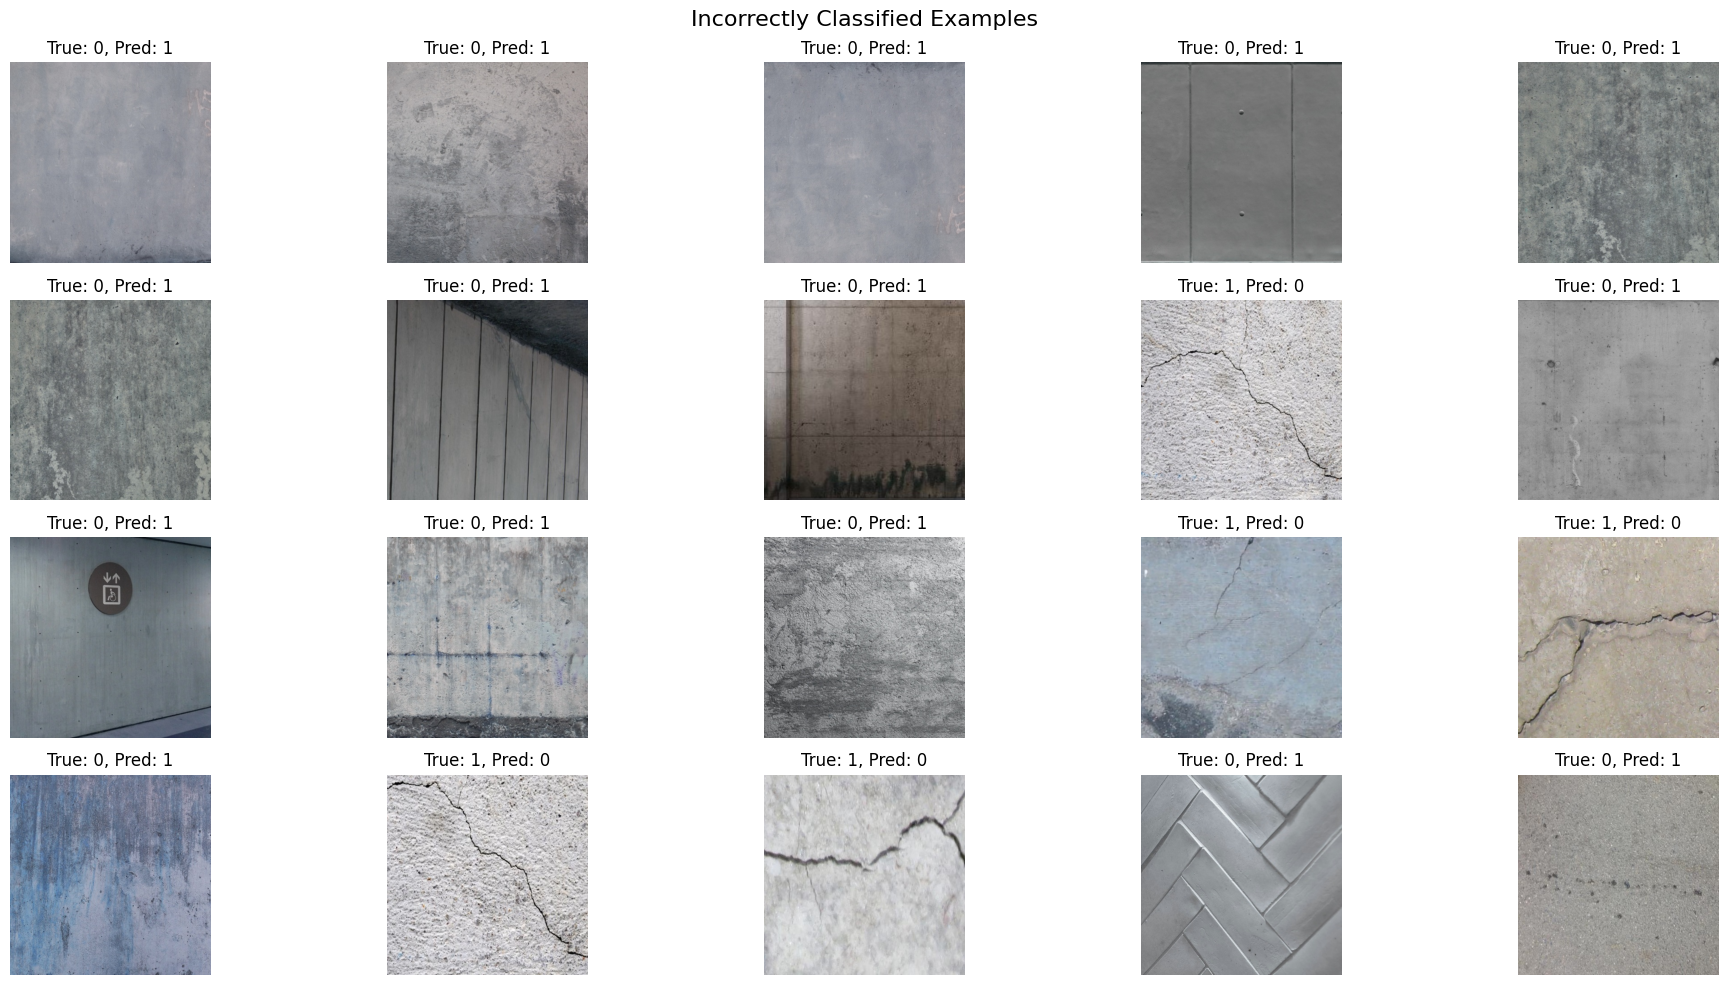

In [134]:
random.seed(44)
correctly_sample = random.sample(correctly_classified_images, min(20, len(correctly_classified_images)))
incorrectly_sample = random.sample(incorrectly_classified_images, min(20, len(incorrectly_classified_images)))

# Function to display images
def display_images(image_data, title):
    fig, axs = plt.subplots(4, 5, figsize=(20, 10))
    axs = axs.flatten()
    for i, (image, true_label, pred_label, image_path) in enumerate(image_data):
        img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        axs[i].imshow(img_rgb)
        axs[i].set_title(f"True: {true_label}, Pred: {pred_label}")
        axs[i].axis('off')
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Display the results
display_images(correctly_sample, "Correctly Classified Examples")
display_images(incorrectly_sample, "Incorrectly Classified Examples")

#### As we can see, the biggest problem is with tiles/ bricks. The pattern is simillar to cracks, as it is a ripple in texture. On the other side there is a problem with not detecting cracks in iamges that have heavy texture like the asphalt photos. Model not only recognizes cracks as ripples in texture, but the txture alone. To adress it we would have to make preprocessing or rather image augumentation that is precise to the field, but we were asked not to do so. So this will be leaved not adresses and we just accept those as cases that are harder to learn.

--------------
## Pixel importance

##### I chose saliency maps to show which pixels are important in classification.
#### The saliency map is calculated by taking the derivatives of the class probability with respect to the input image X. It is simillar concept to backpropagation. 

 #### Through this i observed that cracks are hard to detect, the model learned texture a lot. Tiles on the other hand were easier to spot(the grout parts of them). I showcase this on 2 examples below:

In [135]:
import cv2
model = load_model("best_model.keras")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


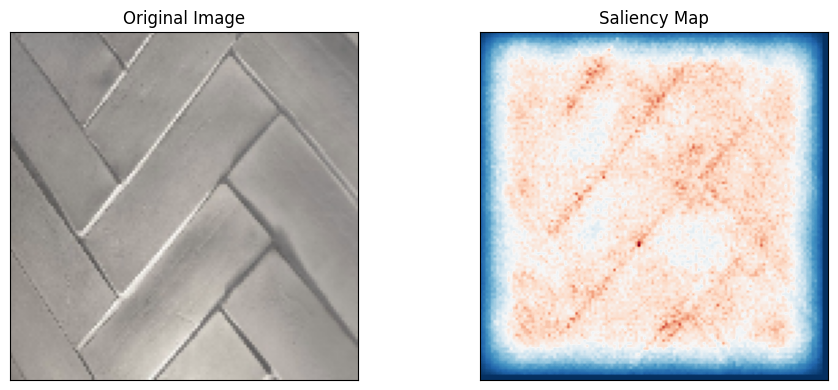

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


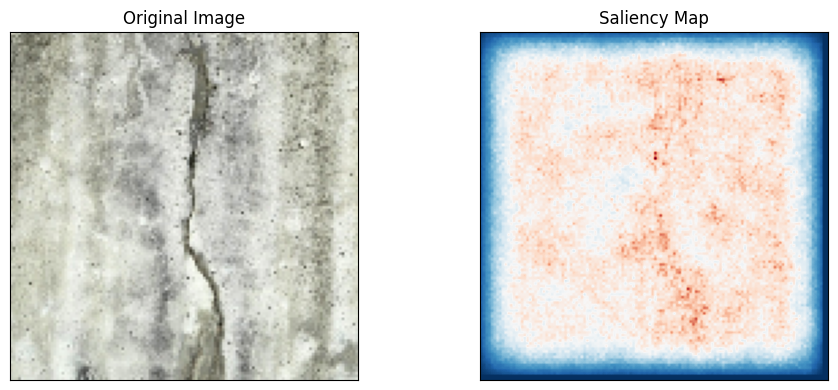

In [137]:
np.random.seed(44)
tf.random.set_seed(44)
def find_layer_idx(model, layer_name):
    for idx, layer in enumerate(model.layers):
        if layer.name == layer_name:
            return idx
    return None

def apply_modifications(model):
    model = tf.keras.models.clone_model(model)
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Activation) and layer.activation == tf.keras.activations.linear:
            layer.activation = tf.keras.activations.linear
    return model


def saliencymap(img_path, model):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (128, 128))
    img = np.array(img) / 255.0
    x = img_to_array(img)  
    pr1 = model.predict(np.expand_dims(x, axis=0))
    
    # swap last layer with linear layer  
    layer_idx = find_layer_idx(model, model.layers[-1].name)
    model.layers[-1].activation = tf.keras.activations.linear
    model = apply_modifications(model)


    score = BinaryScore((pr1 > 0.5).astype("uint8"))

    #Create Saliency object
    saliency = Saliency(model, clone=False)

    # Generate saliency map
    saliency_map = saliency(score, x, smooth_samples=100, smooth_noise=0.2)
    saliency_map = normalize(saliency_map)
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), subplot_kw={'xticks': [], 'yticks': []})
    ax[0].imshow(x / np.max(x))  # Display the original image
    ax[0].set_title("Original Image")

    norm = Normalize(vmin=0, vmax=1)
    ax[1].imshow(saliency_map[0], cmap='RdBu_r', norm=norm)  # Display the saliency map
    ax[1].set_title("Saliency Map")

    plt.tight_layout()
    plt.show()

saliencymap("./test/images/noncrack_noncrack_concrete_wall_13_6.jpg.jpg", model ) #tiles
saliencymap("./test/images/Rissbilder_for_Florian_9S6A2869_855_1425_2447_2662.jpg",model) #some crack

#### In case of tiles, the straight lines are mainly responsible for classification. We can easily see the pattern of tiles. <br> In case of crack, we can (hardly, but..) see the crack (darkder red in the middle). <br> What is interesting, we can observe that borders dont play role in classification at all, which makes sense, as they are somewhat ereased by convolution operation. 